# Evaluation measures for multi-label classification

We first generate multi-labelled random data. These 12x12 images belong to class $i$ iff the $i$-th row contains one and only one pixel. Images can belong to several classes.

In [1]:
%pylab inline
import numpy as np
import h5py
import subprocess
import caffe
from caffe.proto import caffe_pb2
from caffe import layers as L, params as P
from nideep.eval.metrics import example_based_measures, label_based_measures, confusion_matrix_per_class, accuracy_per_class, print_dic
from nideep.eval.metrics import get_inputs_outputs # A SUPPRIMER
from nideep.eval.inference import infer_to_h5_fixed_dims
from learning_curve.mnist_train_test import train_test_net_command

Populating the interactive namespace from numpy and matplotlib


/usr/lib/pymodules/python2.7/matplotlib/__init__.py:1173: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
img_size = (12, 12)
lbl_size = (12,)

nb_train_examples = 82000
nb_test_examples = int(1./3 * nb_train_examples)

train_db_path = "db/train.h5"
test_db_path = "db/test.h5"

def generate_data(img_size, lbl_size, nb_examples, generate_labels=True):
    classes = img_size[0]
    d, l = [], []
    for _ in range(nb_examples):
        data = np.zeros(img_size)
        nb_pixels = np.random.randint(1, classes)
        continue_ = True
        while continue_:
            row = np.random.randint(classes)
            column = np.random.randint(img_size[1])
            if sum(data[row,:]) == 0:
                data[row, column] = 1
            continue_ = np.sum(data) <= nb_pixels
        label = np.sum(data, axis=1).reshape(lbl_size)
        l.append(label)
        d.append([data])
    if generate_labels:
        return np.array(d), np.array(l)
    return np.array([d]), None

def save_data(db_path, key_label, key_data, img_size, lbl_size, nb_examples, generate_labels=True):
    d, l = generate_data(img_size, lbl_size, nb_examples, generate_labels)
    with h5py.File(db_path, 'w') as f:
        f.create_dataset(key_data, (nb_examples, 1, 12, 12), dtype="float32")
        f[key_data][:] = d
        if generate_labels:
            f.create_dataset(key_label, (nb_examples, 12), dtype="float32")
            f[key_label][:] = l
    pass

regenerate_data = False

if regenerate_data:
    save_data(train_db_path, "label", "data", img_size, lbl_size, nb_train_examples)
    save_data(test_db_path, "label", "data", img_size, lbl_size, nb_test_examples)

We define a basic convolutional neural network on the generated data. Ouput loss for backpropagation uses the sigmoid cross-entropy.

In [3]:
def net_(hdf5):
    n = caffe.NetSpec()
    n.data, n.label = L.HDF5Data(batch_size=100, source=hdf5, ntop=2)
    n.conv1 = L.Convolution(n.data, kernel_size=1, num_output=50, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.relu1 = L.ReLU(n.pool1, in_place=True)
    n.conv2 = L.Convolution(n.pool1, kernel_size=1, num_output=50, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.relu2 = L.ReLU(n.pool2, in_place=True)
    n.fc1 =   L.InnerProduct(n.relu2, num_output=500, weight_filler=dict(type='xavier'))
    n.score =   L.InnerProduct(n.fc1, num_output=12, weight_filler=dict(type='xavier'))
    n.loss =  L.SigmoidCrossEntropyLoss(n.score, n.label)
    n.sigmoid = L.Sigmoid(n.score)
    return n.to_proto()

def solver_(s, net_prefix, train_net_path, test_net_path, solver_config_path):
    # Randomization in training
    s.random_seed = 0xCAFFE
    # Locations of the train/test networks
    s.train_net = train_net_path
    s.test_net.append(test_net_path)
    s.test_interval = 1000  # Test after every 'test_interval' training iterations.
    s.test_iter.append(1000) # Test on 'test_iter' batches each time we test.
    s.max_iter = 82000 # Max training iterations
    # Type of solver
    s.type = "Nesterov" # "SGD", "Adam", and "Nesterov"
    # Initial learning rate and momentum
    s.base_lr = 0.01
    s.momentum = 0.9
    s.weight_decay = 5e-4
    # Learning rate changes
    s.lr_policy = 'inv'
    s.gamma = 0.0001
    s.power = 0.75
    # Display current training loss and accuracy every 10 iterations
    s.display = 10
    # Use GPU to train
    s.solver_mode = caffe_pb2.SolverParameter.GPU
    # Snapshots
    s.snapshot_after_train = True
    s.snapshot_prefix = "snaps/" + net_prefix
    return s

We train and solve the given net using caffe.

In [4]:
net_prefix = "net"
s = caffe_pb2.SolverParameter()

# Make prototxts
train_net_path = "proto/train.prototxt"
test_net_path = "proto/test.prototxt"
solver_config_path = "proto/solver.prototxt"
with open(train_net_path, "w") as f:
    f.write(str(net_("db/train.txt")))
with open(test_net_path, "w") as f:
    f.write(str(net_("db/test.txt")))
with open(solver_config_path, "w") as f:
    f.write(str(solver_(s, net_prefix, train_net_path, test_net_path, solver_config_path)))
    
train_net = False

if train_net:
    train_test_net_command(solver_config_path)

We now make $n$ inferences and store chosen keys in an hdf5 file. We can visualize the data and some useful multi-label evaluation measures are computed and displayed.

In [5]:
# Inference
make_inference = False
fpath_h5 = "inf/db.h5"
if make_inference:
    net = caffe.Net(train_net_path, "snaps/net_iter_82000.caffemodel", caffe.TRAIN) # caffe.TEST or caffe.TRAIN???
    keys = ["data", "label", "sigmoid", "score"]
    n = 1000
    x = infer_to_h5_fixed_dims(net, keys, n, fpath_h5, preserve_batch=False)

true labels
[[ 0.  1.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.]]

score obtained (%)
[[ 69.  70.  69.  69.  71.  71.  71.  71.  40.  39.  38.  40.]
 [ 82.  83.  83.  83.  94.  95.  95.  95.  94.  94.  94.  94.]
 [ 23.  23.  24.  23.  24.  23.  23.  23.   8.   8.   8.   8.]]

associated predictions
[[ 1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]

true image 0



/usr/local/lib/python2.7/dist-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/usr/local/lib/python2.7/dist-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


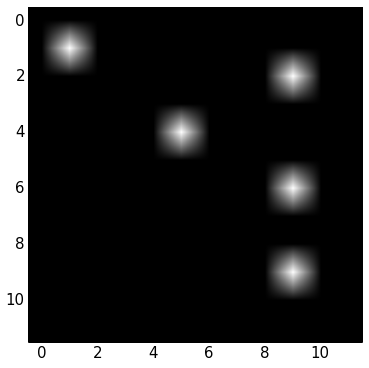

true image 1



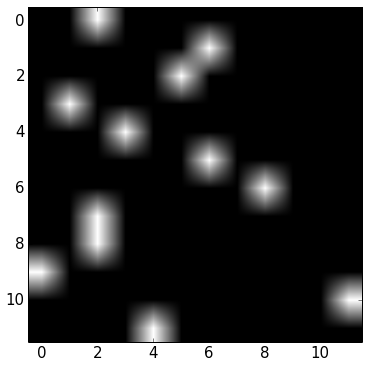

true image 2



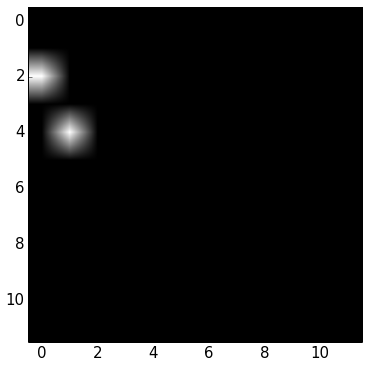

In [6]:
# Visualization of data
nb = 3
key_label = "label"
key_score = "sigmoid"

y_true, y_score, y_pred = get_inputs_outputs(fpath_h5, key_label, key_score, threshold=.5)
with h5py.File(fpath_h5, "r") as f:
    img = f["data"][:]

print "true labels\n", y_true[:nb,:]
print ""
print "score obtained (%)\n", np.rint(100 * y_score[:nb,:])
print ""
print "associated predictions\n", np.rint(y_pred[:nb,:])
print ""
for i in range(nb):
    print "true image {}\n".format(i)
    plt.imshow(np.squeeze(img[i]), cmap='gray')
    plt.show()

/mnt/antares_raid/home/pierre/.virtualenvs/x/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2652: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


Example-based measures
micro_recall
0.803517425937

macro_precision
0.779951454395

macro_recall
0.803516032988

micro_f1
0.791559193917

micro_precision
0.779951675771

macro_f1
0.79155680617

Label-based measures
f1
[ 0.79189566  0.78752635  0.79290886  0.79336644  0.79237749  0.79263386
  0.79102517  0.79334354  0.79134274  0.79138945  0.79150035  0.78937177]

recall
[ 0.80317145  0.79919596  0.80561204  0.8069112   0.80519125  0.80466173
  0.80224804  0.80462927  0.80084058  0.80551365  0.80309621  0.80112102]

accuracy_score
0.08609

hamming_loss
0.247215833333

precision
[ 0.78093208  0.77619262  0.78060008  0.78026891  0.77996517  0.78096028
  0.78011197  0.78237001  0.78206754  0.77775203  0.78023459  0.77796216]

Correlation matrices
0
[[28447 13157]
 [11494 46902]]

1
[[28381 13413]
 [11688 46518]]

2
[[28233 13250]
 [11375 47142]]

3
[[28332 13270]
 [11276 47122]]

4
[[28327 13267]
 [11378 47028]]

5
[[28274 13207]
 [11431 47088]]

6
[[28659 13157]
 [11506 46678]]

7
[[28251

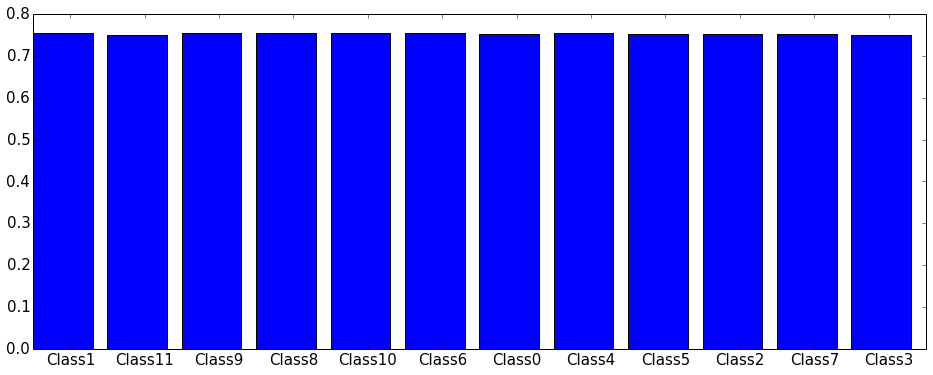

In [7]:
# Compute metrics
key_label, key_score = "label", "sigmoid"

measures1 = example_based_measures(fpath_h5, key_label, key_score, threshold=.5)
measures2 = label_based_measures(fpath_h5, key_label, key_score, threshold=.5)
cm = confusion_matrix_per_class(fpath_h5, key_label, key_score, threshold=.5)
acc = accuracy_per_class(fpath_h5, key_label, key_score, threshold=.5)

# Inline display of measures and confusion matrices for each class
print "====================="
print "Example-based measures"
print "====================="
print_dic(measures1)
print "====================="
print "Label-based measures"
print "====================="
print_dic(measures2)
print "====================="
print "Correlation matrices"
print "====================="
print_dic(cm)

# Histogram of accuracies for each class
fig, ax = plt.subplots()
classes, accuracies = zip(*sorted(acc.items(), key=lambda tup: tup[1]))
plt.bar(classes, accuracies)
xTickMarks = ['Class'+str(i) for i in classes]
ax.set_xticks([x+.5 for x in range(12)])
xtickNames = ax.set_xticklabels(xTickMarks)
plt.show()